In [53]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import rioxarray as rxr
import numpy as np 

## Data collection

In [54]:
# Function to clip the TIFF file
def clip_tiff(file_path, lon_min, lon_max, lat_min, lat_max):
    data = rxr.open_rasterio(file_path)
    clipped_data = data.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
    return clipped_data

### Define the bounding box

In [55]:
south_korea_lat_min = 38
south_korea_lat_max = 39
south_korea_lon_min = 126
south_korea_lon_max = 128.5

### Aggregate data files

In [23]:
# Base directory containing the folders
base_dir = '/home/tom/Documents/UC/Pixel data'

# Dataset to store the clipped data
dataset = []
counter = 0
# Loop through each year directory
for year in os.listdir(base_dir):
    year_dir = os.path.join(base_dir, year)

    # Loop through each subdirectory in the year directory
    for root, dirs, files in os.walk(year_dir):
        for file in files:
            if file.endswith("-CL.tif"):
                file_path = os.path.join(root, file)

                # Extract the 'month' from the directory name if necessary
                month = os.path.basename(root)  # or any other logic to determine the month from the folder name

                # Clip the data and add to the dataset
                clipped_data = clip_tiff(file_path, south_korea_lon_min, south_korea_lon_max, south_korea_lat_min, south_korea_lat_max)
                clipped_data = clipped_data.squeeze() # Remove the band data
                clipped_data = clipped_data.assign_coords({"month": counter})
                clipper_data = clipped_data.expand_dims(dim = "month")
                dataset.append(clipped_data)
                counter += 1

# Concatenate all DataArrays in the dataset list along the 'month' dimension
combined_data = xr.concat(dataset, dim="month")

combined_data.rio.to_raster("combined-CL-smaller.tif")

In [24]:
combined_data.shape

(240, 447, 1114)

In [31]:
combined_data[0][2000][0]

<xarray.DataArray ()>
array(0, dtype=uint8)
Coordinates:
    band         int64 1
    x            float64 125.0
    y            float64 34.51
    spatial_ref  int64 0
    month        int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## Data visualisation

In [58]:
import matplotlib.animation as animation
import matplotlib.colorbar as colorbar

combined_data = rxr.open_rasterio('combined-CL.tif')
combined_data

<xarray.DataArray (band: 240, y: 3118, x: 2227)>
[1666508640 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240
  * x            (x) float64 125.0 125.0 125.0 125.0 ... 130.0 130.0 130.0 130.0
  * y            (y) float64 39.0 39.0 39.0 38.99 ... 32.01 32.01 32.0 32.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

## 

### Classify pixels as either burned, unburned or unburnable based on confidence level

In [59]:
for i, data in enumerate(combined_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    combined_data[i] = new_data
np.unique(combined_data)


array([0, 1, 2], dtype=uint8)

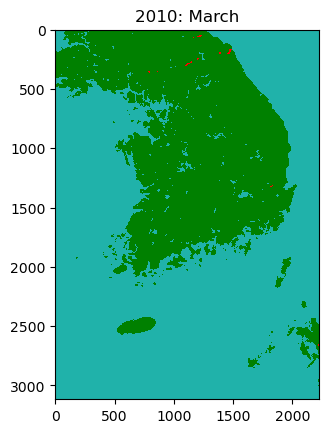

In [23]:
month_dict = {
    0 : 'January',
    1 : 'February',
    2:  'March',
    3: 'April',
    4: 'May',
    5: 'June',
    6: 'July',
    7: 'August',
    8: 'September',
    9: 'October',
    10: 'November',
    11: ' December'
}

n = 110
cmap = mpl.colors.ListedColormap(["lightseagreen", "green", "red"])
fig, ax = plt.subplots()
test = ax.imshow(combined_data[n], cmap=cmap, vmin=0, vmax=2)
ax.set_title(f'{2001 + (n // 12)}: {month_dict[n % 12]}')

plt.show()

### Generate animation of Dataset

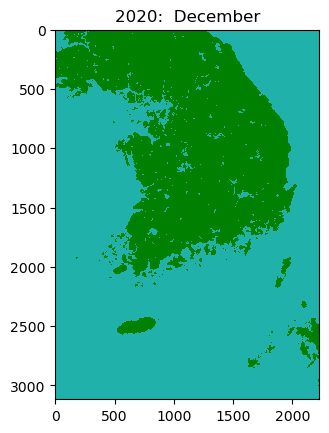

In [25]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    object = ax.imshow(combined_data[i], cmap=cmap, vmin=0, vmax=2)
    ax.set_title(f'{2001 + (i // 12)}: {month_dict[i % 12]}')
    return [object]

ani = animation.FuncAnimation(fig, animate, repeat=False, blit=True, frames=240, interval=400)
# To save the animation using Pillow as a gif

ani.save('scatter.gif', writer=animation.PillowWriter(fps=1))

## STAR implementation

In [34]:
from scipy.signal import convolve2d
from scipy import optimize
from scipy.optimize import LinearConstraint

In [5]:
def STAR(dataset, rho, c, phi, labda):
    '''
    Calculates the Space-Time Autoregression for a dataset Y using rho timelags. 
    
    Parameters:
    dataset: dataset for which to calculate the next timestep. First axis is the time-axis
    rho: maximum timelag 
    c: constant
    phi: parametervector of size tau
    labda: parametervector of size tau
    
    returns: predicction for dataset at timestep t. Same shape as a single timeslice of the dataset.
    '''
    
    y_t = np.zeros(shape=(dataset.shape[1], dataset.shape[2])) #initialize matrix
    y_t += c #add constant
    for tau in range(rho):
        y_t += phi[tau] * dataset[-(1+tau)] 
        y_t += labda[tau] * convolve2d(dataset[-(1+tau)], [[0,1,0],[1,0,1],[0,1,0]], mode='same') # rook's case convolution
        
    return y_t


In [36]:
combined_data = rxr.open_rasterio('combined-CL-smaller.tif')
combined_data

<xarray.DataArray (band: 240, y: 447, x: 1114)>
[119509920 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 234 235 236 237 238 239 240
  * x            (x) float64 126.0 126.0 126.0 126.0 ... 128.5 128.5 128.5 128.5
  * y            (y) float64 39.0 39.0 39.0 38.99 38.99 ... 38.01 38.0 38.0 38.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

### Finding optimal parameters

To find the optimal autoregression parameters we will use the scipy optimize library. The optimization algorithms work on scalar functions, so we first need to define a scalar loss function to minimize. 
We will us use the Frobenius Norm of the difference between the observation and the prediction.  

In [7]:
def loss(x, rho, historic_data, label):
    '''
    x contains all parameters: In order: ( c, [phi], [labda])
    '''
    c = x[0]
    phi = [x[1 + i] for i in range(rho)]
    labda = [x[1 + rho] for i in range(rho)]
    res = STAR(historic_data, rho, c, phi, labda)

    return np.linalg.norm(res - label)

### helper function for generating the right argument format

In [63]:
def create_x_plus_bounds(rho):
    '''
    bounds for variables phi and labda are (0,1) for each timestep, c can be in range (0,100)
    '''
    phi_list = np.random.rand(rho)
    labda_list = np.random.rand(rho)
    
    x = [1]
    for phi in phi_list : x.append(phi)
    for labda in labda_list : x.append(labda)
    
    bounds_arr = [(-1,1) for i in range(2*rho)]
    #bounds_arr.append([(0,1) for i in range(rho)])
    bounds_arr.insert(0, (0,100)) # [(0,100), (0,1), (0,1), ... , (0,1)] for legnth phi and labda 
    
    return x, bounds_arr

#test
print(create_x_plus_bounds(3))

([1, 0.9691355909777265, 0.4475403152650521, 0.06655014875257581, 0.8273650307528269, 0.018756239716612333, 0.9958018528437328], [(0, 100), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)])


### Training the model

The model was trained for one hundred iterations of the optimization procedure. The resulting model parameters were pickled and saved.

In [ ]:
# WARNING: extremely long runtime
import pickle 

rho = 36

historic_data = combined_data[0:110]
label = combined_data[110]
x, bounds = create_x_plus_bounds(rho)
result = optimize.minimize(loss, method='L-BFGS-B', x0=x, args=(rho, historic_data, label,), constraints=(), bounds=bounds, options={'disp':True, 'maxiter':100, 'iprint':99})

print(result)

file = open('result-smaller-2', 'wb')
pickle.dump(result, file)
file.close()


## Trained model analysis

### load in the train results

In [42]:
import pickle 

file = open('result-smaller-2', 'rb')
train_results = pickle.load(file)
file.close()
train_results

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 4641.763891284646
        x: [ 1.418e-02 -2.225e-01 ...  6.050e-01  4.184e-01]
      nit: 100
      jac: [-2.298e+00 -3.619e+00 ...  0.000e+00  0.000e+00]
     nfev: 8806
     njev: 119
 hess_inv: <73x73 LbfgsInvHessProduct with dtype=float64>

### Inspect model paramaters

In [65]:
c = train_results.x[0]
rho = int((len(train_results.x) - 1) /2)

phi = train_results.x[1:rho+1]
labda = train_results.x[rho+1:]

print(f'c: {c}, \nrho: {rho} \nphi: {phi}\nlambda:{labda}')
print(f'Phi mean: {np.mean(phi)}, var: {np.var(phi)}')
print(f'Lambda mean: {np.mean(labda)}, var: {np.var(labda)}')


c: 0.014179353670657022, 
rho: 36 
phi: [-0.22245044  0.86706979 -0.34504799 -0.25921133  0.1227092   0.19345596
 -0.11269037  0.44243205 -0.28194385  0.03958465 -0.01233126 -0.11050706
 -0.02246427 -0.21843105 -0.28087128 -0.19786379  0.01960351  0.13639688
 -0.06261446  0.31061789 -0.0022938  -0.04522465  0.00340457  0.1423823
 -0.05399917  0.47424438  0.19970834 -0.3986271  -0.07187063  0.16128755
  0.12217244 -0.18801482 -0.18069984 -0.01941568 -0.01526283  0.0452862 ]
lambda:[0.00793576 0.94835495 0.29267234 0.23036249 0.99127934 0.20415577
 0.03453094 0.67081439 0.03312529 0.34369263 0.77431362 0.16478917
 0.50823472 0.88468336 0.6199042  0.22550829 0.36132888 0.65010031
 0.99245181 0.02402335 0.00401634 0.87876054 0.8366571  0.04871742
 0.42967201 0.22233689 0.05189117 0.07465901 0.28073942 0.79047871
 0.46007034 0.49310289 0.03698592 0.37411131 0.60502672 0.41836976]
Phi mean: 0.004958889589227998, var: 0.06089916944102955
Lambda mean: 0.4157738090420293, var: 0.100250417868200

### Recreating figure 13 (a) from 'Modeling Historical and Future Forest Fires in South Korea: The FLAM Optimization Approach' by Jo et. al.

We predict the burning frequency per pixel for the data from January 2016 to December 2019 and plot this against the observed frequency.

In [24]:
# Load in the dataset 
CL_data = rxr.open_rasterio('combined-CL-smaller.tif')

# Convert CL-value to burned/unburned class
class_data = np.zeros(shape=CL_data.shape)
for i, data in enumerate(CL_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    class_data[i] = new_data

#STAR(dataset, rho, c, phi, labda)

In [25]:
# Fill matrix with prediction values
Prediction_arr = np.zeros(shape=CL_data.shape) #note : not all values will be filled

for i in range(12 * 16, 12*19): # indeces of January 2016 to December 2019
    prediction = STAR(CL_data[:i], rho, c, phi, labda)
    Prediction_arr[i] = prediction

In [26]:
#Convert predictions to burned/unburned class
pred_class_data = np.zeros(shape=Prediction_arr.shape)
for i, data in enumerate(Prediction_arr):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    pred_class_data[i] = new_data

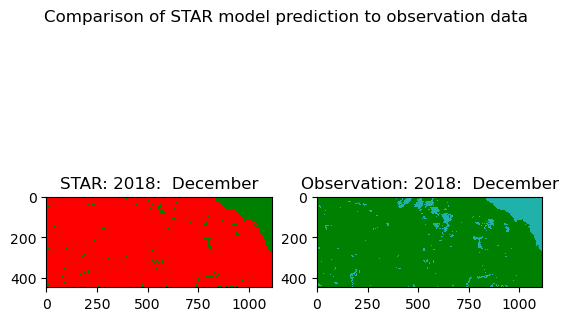

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison of STAR model prediction to observation data')

def animate(i):
    ax1.clear()
    ax2.clear()
    object1 = ax1.imshow(pred_class_data[(12*16) + i], cmap=cmap, vmin=0, vmax=2)
    object2 = ax2.imshow(class_data[(12*16) + i], cmap=cmap, vmin=0, vmax=2)
    ax1.set_title(f'STAR: {2016 + (i // 12)}: {month_dict[i % 12]}')
    ax2.set_title(f'Observation: {2016 + (i // 12)}: {month_dict[i % 12]}')
    return [object1, object2]

ani = animation.FuncAnimation(fig, animate, repeat=False, blit=True, frames=36, interval=400)
# To save the animation using Pillow as a gif

ani.save('STAR-comparison-smaller-2.gif', writer=animation.PillowWriter(fps=1))

In [19]:
def count_pixel_occurrences(dataset):
    """
    Count the occurrences of a specific value (2) in each pixel across all months.

    :param dataset: A numpy array of shape (months, height, width).
    :return: A numpy array of shape (height, width) with the count of occurrences.
    """
    months, height, width = dataset.shape
    count_matrix = np.zeros((height, width), dtype=int)

    for month in range(months):
        count_matrix += (dataset[month] == 2)

    return count_matrix / dataset.shape[0]

In [27]:
prediction_matrix = count_pixel_occurrences(pred_class_data[12*16:12*19])
print(f'Unique values in the matrix: {np.unique(prediction_matrix)}')

observation_matrix = count_pixel_occurrences(class_data[12*16:12*19])
print(f'Unique values in the matrix: {np.unique(observation_matrix)}')

Unique values in the matrix: [0.         0.02777778 0.05555556 0.08333333 0.11111111 0.13888889
 0.16666667 0.19444444 0.22222222 0.25       0.27777778 0.30555556
 0.33333333 0.36111111 0.38888889 0.41666667 0.44444444 0.47222222
 0.5        0.52777778 0.55555556 0.58333333 0.61111111 0.63888889
 0.66666667 0.69444444 0.72222222 0.75       0.77777778 0.80555556
 0.83333333 0.86111111 0.88888889 0.91666667 0.94444444 0.97222222
 1.        ]
Unique values in the matrix: [0.         0.02777778 0.05555556 0.08333333]


In [29]:
def combine_matrices(matrix1, matrix2):
    """
    Combine two matrices into a new matrix where each pixel contains a tuple of values from both matrices.

    :param matrix1: A numpy array of shape (x, y).
    :param matrix2: A numpy array of shape (x, y).
    :return: A numpy array of shape (x, y) with tuples as elements.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape")

    height, width = matrix1.shape
    combined_matrix = np.empty((height, width), dtype=object)

    for i in range(height):
        for j in range(width):
            combined_matrix[i, j] = (matrix1[i, j], matrix2[i, j])

    return combined_matrix

freq_matrix = combine_matrices(prediction_matrix, observation_matrix)

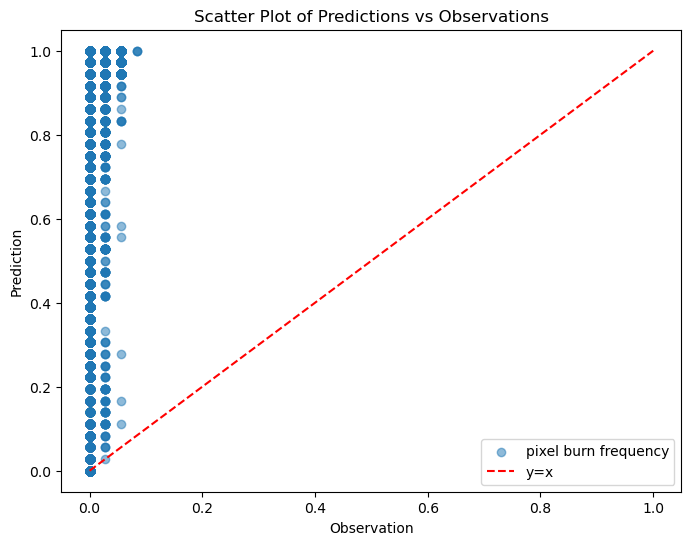

In [33]:
def create_scatter_plot(matrix):
    """
    Create a scatter plot from a matrix of tuples, where the first value in each tuple is plotted on the y-axis
    and the second value is plotted on the x-axis.

    :param matrix: A numpy array of shape (x, y) with tuples as elements.
    """
    # Extracting x and y values from the tuples
    x_values = np.array([elem[1] for row in matrix for elem in row])
    y_values = np.array([elem[0] for row in matrix for elem in row])

    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, alpha=0.5, label='pixel burn frequency')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')

    # Drawing the line y = x
    max_value = max(max(x_values), max(y_values))
    plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')  # Red dashed line

    plt.title('Scatter Plot of Predictions vs Observations')
    plt.legend()
    plt.show()

create_scatter_plot(freq_matrix)